In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

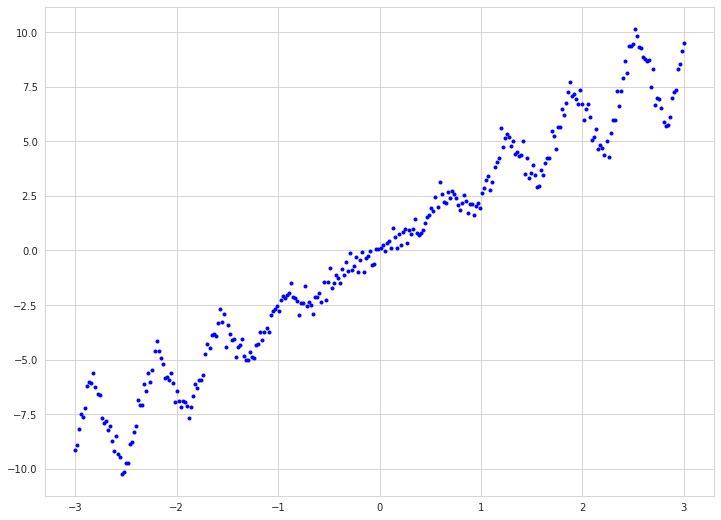

In [4]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [5]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

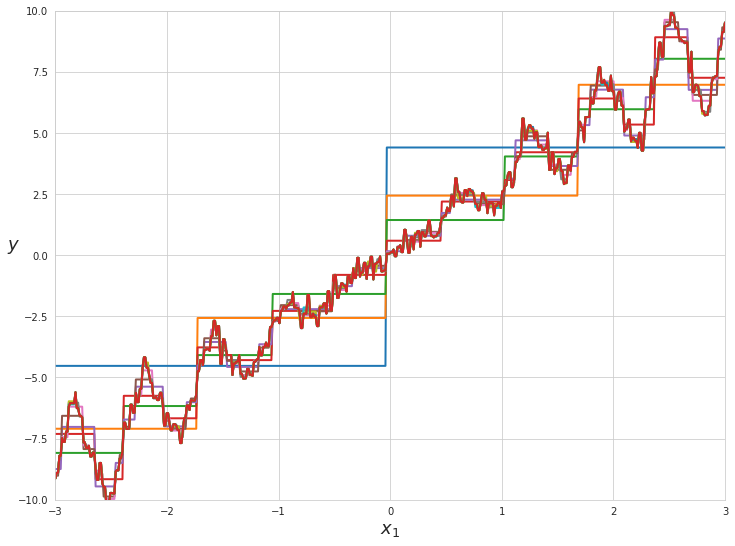

In [7]:
#plt.figure(figsize=(10, 10))

for i in range(1, 15):
    clf = DecisionTreeRegressor(max_depth=i, random_state=0)
    clf.fit(X, y)
    plot_regression_predictions(clf, X, y)

plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

from scipy.special import comb

def func(p,n):
    s=0
    majority = n // 2 + 1
    for i in range(majority,n+1):
        s+=comb(n,i)*np.power(p,i)*np.power(1-p,n-i)
    return s

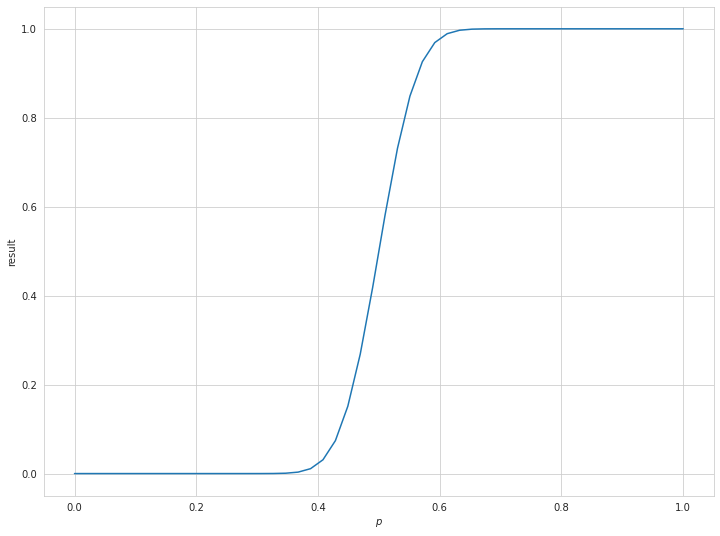

In [9]:
probs=np.linspace(0,1,num=50)
result=[func(p,101) for p in probs]
plt.plot(probs, result)
plt.xlabel("$p$")
plt.ylabel("result")
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

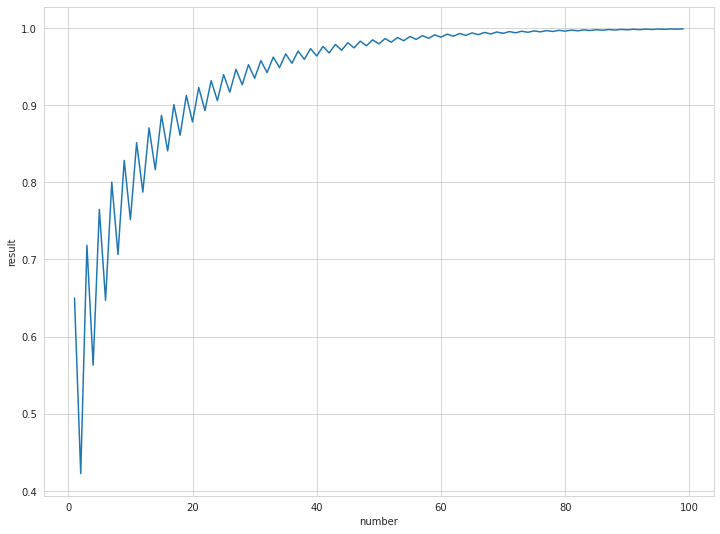

In [10]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

number = [i for i in range(1,100)]
result=[func(0.65,n) for n in number]
plt.plot(number, result)
plt.xlabel("number")
plt.ylabel("result")
plt.show()

Опишите ваши наблюдения:

1) Зависимость вероятности правильно предсказать класс объекта от p возрастающая, похожа на ФР нормального распределения

2) График похож на пилу, но пикам и впадинам возрастает к 1 c увеличением числа классификаторов

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
from sklearn.metrics import accuracy_score, f1_score

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feat_ids_by_tree = []
        self.n_classes=None

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        n_samples,n_feats = X.shape
        self.bag_size = n_samples
        for i in range(0,self.n_estimators):
            SEED = self.random_state+i
            random.seed(SEED)
            np.random.seed(SEED) 
            feat_idx = np.random.choice([i for i in range(n_feats)],size=self.max_features,replace=False)
            train_idx = np.random.choice([i for i in range(n_samples)],size=self.bag_size,replace=True)
            clf = DecisionTreeClassifier(max_depth = self.max_depth,max_features=self.max_features,
                                         random_state=self.random_state)
            
            X_bootstrap = X[train_idx,:][:,feat_idx]
            y_bootstrap = y[train_idx]
            
            clf.fit(X_bootstrap,y_bootstrap)
            
            self.feat_ids_by_tree.append(feat_idx)
            self.trees.append(clf)
        
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        n_samples,_ = X.shape
        predicts=np.zeros((n_samples,len(self.classes_)))
        for i in range(0,self.n_estimators):
            predicts+=self.trees[i].predict_proba(X[:,self.feat_ids_by_tree[i]])
        return predicts/self.n_estimators
        #pass
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions
    
    def score(self, X, y):
        return accuracy_score(y,self.predict(X))

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

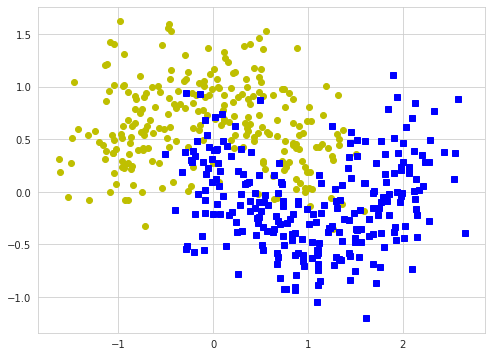

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

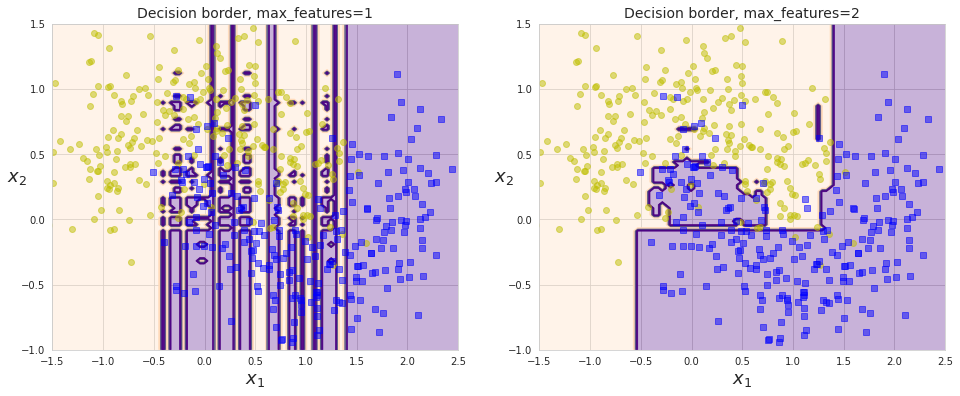

In [14]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf1 = RandomForestClassifierCustom(max_features = 1, n_estimators=20, max_depth=20,random_state=42)
clf1.fit(X_train, y_train)

clf2 = RandomForestClassifierCustom(max_features = 2, n_estimators=20, max_depth=20,random_state=42)
clf2.fit(X_train, y_train)


plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border, max_features=1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X,y)
plt.title("Decision border, max_features=2", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[i for i in range(1,21)],'max_depth':[i for i in range(1,21)]}
rndf = RandomForestClassifierCustom(max_features=1,random_state=42)
clf = GridSearchCV(rndf, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 3, 'n_estimators': 14}

In [17]:
clf.score(X_test,y_test)

0.864

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[i for i in range(1,21)],'max_depth':[i for i in range(1,21)]}
rndf = RandomForestClassifierCustom(max_features=2,random_state=42)
clf = GridSearchCV(rndf, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 8, 'n_estimators': 13}

In [19]:
clf.score(X_test,y_test)

0.904

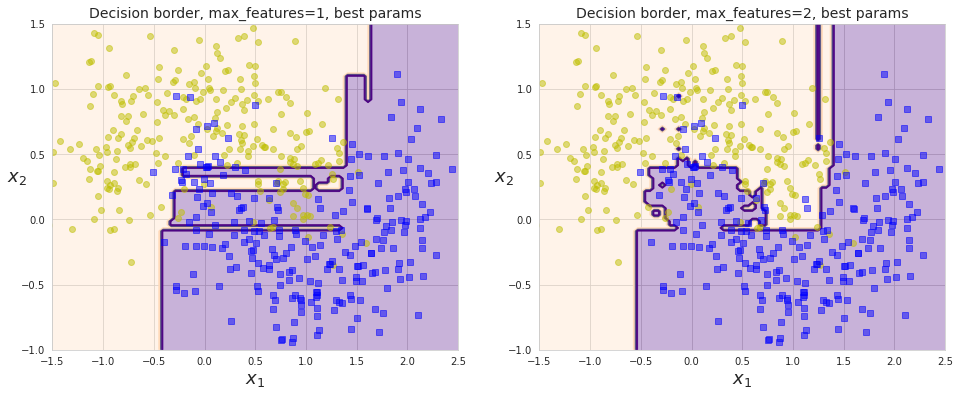

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf1 = RandomForestClassifierCustom(max_features = 1, n_estimators=14, max_depth=3,random_state=42)
clf1.fit(X_train, y_train)

clf2 = RandomForestClassifierCustom(max_features = 2, n_estimators=13, max_depth=8,random_state=42)
clf2.fit(X_train, y_train)


plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border, max_features=1, best params", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X,y)
plt.title("Decision border, max_features=2, best params", fontsize=14)
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [21]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [22]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [28]:
max_feats_list = [1,3,5,10,15,20,25,30]
corr_list = []
for max_features in max_feats_list:
    clf = RandomForestClassifier(max_features=max_features,max_depth=20)
    clf.fit(X_train,y_train)
    corr_list.append(base_model_pair_correlation(clf, X_train))

([<matplotlib.axis.XTick at 0x7f70d135fe50>,
 [Text(1, 0, '1'),
  Text(2, 0, '3'),
  Text(3, 0, '5'),
  Text(4, 0, '10'),
  Text(5, 0, '15'),
  Text(6, 0, '20'),
  Text(7, 0, '25'),
  Text(8, 0, '30')])

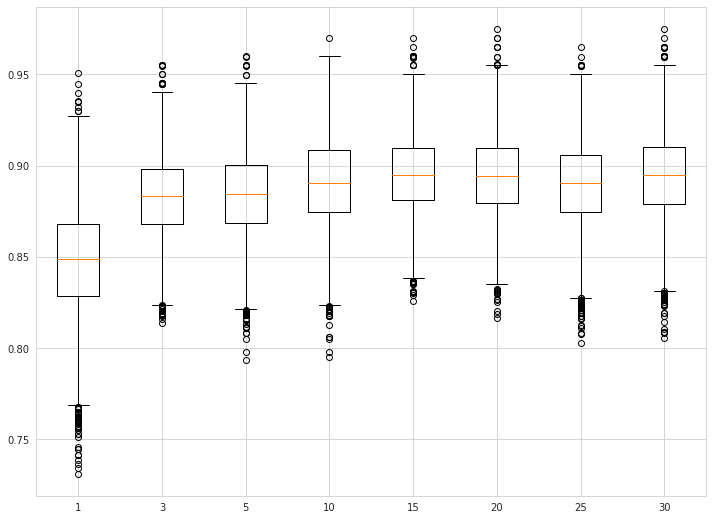

In [29]:
plt.boxplot(corr_list)
plt.xticks([1, 2, 3, 4, 5, 6,7,8],max_feats_list)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

([<matplotlib.axis.XTick at 0x7f70c9341c40>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '5'),
  Text(5, 0, '10'),
  Text(6, 0, '15'),
  Text(7, 0, '20'),
  Text(8, 0, '25'),
  Text(9, 0, '30'),
  Text(10, 0, '')])

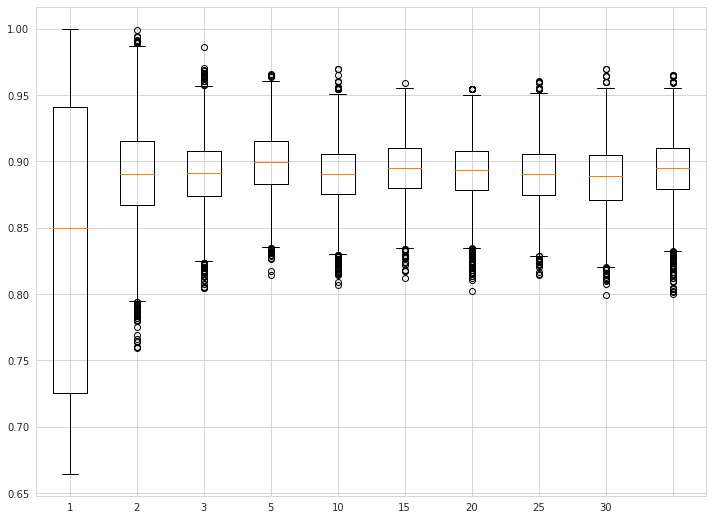

In [32]:
max_depth_list = [1,2,3,5,10,15,20,25,30,None]
corr_list = []
for max_depth in max_depth_list:
    clf = RandomForestClassifier(max_features=20,max_depth=max_depth)
    clf.fit(X_train,y_train)
    corr_list.append(base_model_pair_correlation(clf, X_train))
    
plt.boxplot(corr_list)
plt.xticks([1, 2, 3, 4, 5, 6,7,8,9, 10],max_depth_list)

Опишите ваши наблюдения:

1) С увеличением max_features, средняя корреляция деревьев немного растёт, но в целом постоянна

2) С увеличением max_depth, cредняя корреляция деревьев в целом постоянна

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [211]:
#!pip install gdown
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [212]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [181]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]



Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [182]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

for bs in base_models:
    model_name, model = bs
    model.fit(X_train,y_train)

    
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')

voting_hard.fit(X_train,y_train)
voting_soft.fit(X_train,y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[19:02:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [183]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [184]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X_train)

Нарисуем корреляции

<AxesSubplot:>

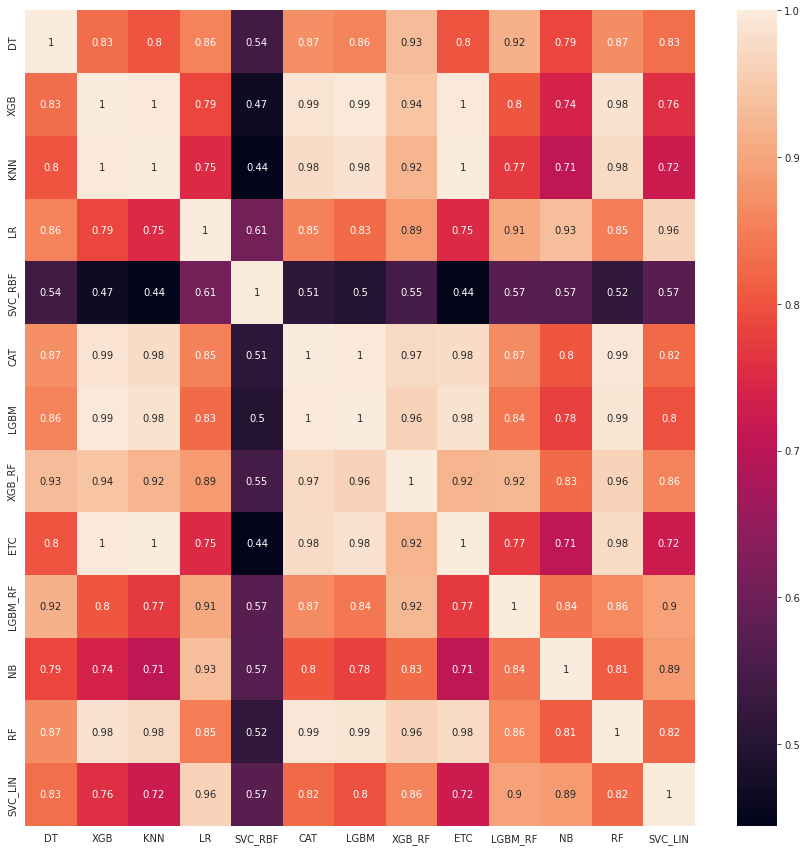

In [185]:
#corrs[0][0].__class__.__name__
corrs_names = { (str(p[0]), str(p[1])): p[2] for p in corrs }
name2short_name = { str(p[1]):p[0] for p in base_models }
map_uniq = {name:i for i,name in enumerate(list(set([p[0] for p in corrs_names.keys()]+[p[1] for p in corrs_names.keys()])))}
name2short_name[[v for v in map_uniq.keys() if 'catboost' in v][0]] = 'CAT'
N = len(base_models)
heatmap = np.ones((N,N))

for p,val in corrs_names.items():
    i = map_uniq[p[0]]
    j = map_uniq[p[1]]
    heatmap[i,j] = val
    heatmap[j,i] = val

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15)) 

yticklabels = [name2short_name[name] for name in  map_uniq.keys()]
xticklabels = [name2short_name[name] for name in  map_uniq.keys()]
sns.heatmap(heatmap,annot=True, xticklabels=xticklabels, yticklabels=yticklabels, ax = ax)
#ax.set_yticks(yticklabels)
    

In [214]:
for model in [p[1] for p in base_models]+[voting_hard, voting_soft]:
    #scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__} {f1_score(y_test,model.predict(X_test))}")

DecisionTreeClassifier 0.8703703703703703
RandomForestClassifier 0.8484848484848485
ExtraTreesClassifier 0.8775510204081632
KNeighborsClassifier 0.6597938144329897
SVC 0.8712871287128713
SVC 0.7102803738317757
CatBoostClassifier 0.8823529411764706
LGBMClassifier 0.8627450980392157
LGBMClassifier 0.8431372549019609
XGBClassifier 0.8653846153846154
XGBRFClassifier 0.8627450980392157
LogisticRegression 0.88
GaussianNB 0.9072164948453608
VotingClassifier 0.8737864077669905
VotingClassifier 0.8737864077669905


Напишем более быструю версию soft VotingClassifier для перебора наборов моделей в ансамбле

In [95]:
est_list=[] 
for est in voting_soft.estimators_:
    est_list.append(est.predict_proba(X_test))
mat = np.array(est_list)

def brute_fast(weight):
    y_pred = np.argmax(np.einsum('abc,a -> bc',mat, weight),axis=1)
    return f1_score(y_test,y_pred)

In [96]:
from tqdm import tqdm

grid = list(np.array(np.meshgrid(*[np.linspace(0, 1, num=2) for i in range(13)])).reshape(-1,13))
max_f1=0
best_weights=None
for arr in tqdm(grid):
    f1 = brute_fast(arr)
    if max_f1 < f1:
        max_f1 = f1
        best_weights = arr

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:03<00:00, 2575.52it/s]


In [97]:
best_weights

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

In [98]:
voting_soft = VotingClassifier(base_models,weights=best_weights, voting='soft')
voting_soft.fit(X_train,y_train)
f1_test = f1_score(y_test,voting_soft.predict(X_test))

[08:34:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:34:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [99]:
f1_test

0.9072164948453608

Теперь обучим свою систему

Для начала потюним параметры каждого классификатора

In [215]:
dt = DecisionTreeClassifier(random_state=SEED, min_samples_leaf=10)
rf = RandomForestClassifier(random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier()
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models_new = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

param = {"DT":{ 'criterion':['gini','entropy'],'max_depth': [5,10,15,None]},
        "RF":{ 'criterion':['gini','entropy'],'max_depth': [5,10,15,None],'n_estimators':[50,100]},
         "ETC": None,
         "KNN": {'n_neighbors':[4,5,6,8,10],'weights':['uniform', 'distance']},
         "SVC_LIN":None,
         "SVC_RBF":None,
         'CAT':None,
         "LGBM":{'max_depth':[5,10,20,-1],'learning_rate':[0.1,0.5]},
         "LGBM_RF":{'max_depth':[5,10,20,-1],'learning_rate':[0.1,0.5]},
         "XGB":None,
         "XGB_RF":None,
         "LR":None,
         "NB":None}

tuned_models=[]

In [216]:
from sklearn.model_selection import GridSearchCV

for bs in base_models_new:
    model_name, model = bs
    print(model_name)
    if param[model_name] is None:
        model.fit(X_train,y_train)
        tuned_models.append((model_name, model))
    else:
        grid_cv = GridSearchCV(model,param[model_name],cv=3, scoring="f1")
        grid_cv.fit(X_train,y_train)
        tuned_models.append((model_name, grid_cv))

    
voting_hard = VotingClassifier(tuned_models, voting='hard')
voting_soft = VotingClassifier(tuned_models, voting='soft')
voting_hard.fit(X_train,y_train)
voting_soft.fit(X_train,y_train)

DT
RF
ETC
KNN
SVC_LIN
SVC_RBF
CAT
LGBM
LGBM_RF
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, sub

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[19:38:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('DT',
                              GridSearchCV(cv=3,
                                           estimator=DecisionTreeClassifier(min_samples_leaf=10,
                                                                            random_state=111),
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [5, 10, 15,
                                                                     None]},
                                           scoring='f1')),
                             ('RF',
                              GridSearchCV(cv=3,
                                           estimator=RandomForestClassifier(random_state=111),
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
           

In [36]:
#for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
for model in [p[1] for p in tuned_models]+[voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

GridSearchCV: 0.8042172739541161
GridSearchCV: 0.823852371511362
ExtraTreesClassifier: 0.828174603174603
GridSearchCV: 0.637921976302258
SVC: 0.8403098469098905
SVC: 0.6973119072190279
CatBoostClassifier: 0.8342715174922052
GridSearchCV: 0.812015626649773
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[07:57:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:57:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

In [ ]:
for model in [p[1] for p in tuned_models]+[voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

Уже f1 0,87

In [87]:
f1_score(y_test,voting_soft.predict(X_test))

0.8737864077669905

In [217]:
for model in [p[1] for p in tuned_models]+[voting_hard, voting_soft]:
    #scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__} {f1_score(y_test,model.predict(X_test))}")

GridSearchCV 0.8703703703703703
GridSearchCV 0.8600000000000001
ExtraTreesClassifier 0.8775510204081632
GridSearchCV 0.6153846153846154
SVC 0.8712871287128713
SVC 0.7102803738317757
CatBoostClassifier 0.8823529411764706
GridSearchCV 0.8627450980392157
GridSearchCV 0.8431372549019609
XGBClassifier 0.8653846153846154
XGBRFClassifier 0.8627450980392157
LogisticRegression 0.88
GaussianNB 0.9072164948453608
VotingClassifier 0.8737864077669905
VotingClassifier 0.8737864077669905


Реализуем быструю версию VotingClassifier для перебора весов на тесте для наилучшего качества

In [89]:
est_list=[] 
for est in voting_soft.estimators_:
    est_list.append(est.predict_proba(X_test))
mat = np.array(est_list)

def brute_fast(weight):
    y_pred = np.argmax(np.einsum('abc,a -> bc',mat, weight),axis=1)
    return f1_score(y_test,y_pred)

In [83]:
from tqdm import tqdm

grid = list(np.array(np.meshgrid(*[np.linspace(0, 1, num=2) for i in range(13)])).reshape(-1,13))
max_f1=0
best_weights=None
for arr in tqdm(grid):
    f1 = brute_fast(arr)
    if max_f1 < f1:
        max_f1 = f1
        best_weights = arr

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:02<00:00, 2794.10it/s]


In [84]:
best_weights

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

In [76]:
voting_soft = VotingClassifier(tuned_models,weights=best_weights, voting='soft')
voting_soft.fit(X_train,y_train)
f1_test = f1_score(y_test,voting_soft.predict(X_test))

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

In [77]:
f1_test

0.9072164948453608

Несмотря на тюнинг отдельных моделей, максимальное качество ансамбля не изменилось

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [226]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [227]:
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [228]:
data_dropped=data.drop(['State','Area Code','Phone'],axis=1)

In [229]:
np.unique(data_dropped['Churn?'],return_counts=True)

(array(['False.', 'True.'], dtype=object), array([2850,  483]))

In [230]:
data_dropped['Churn?']=data_dropped['Churn?'].apply(lambda x:1 if x=="True." else 0 )
data_dropped["Int'l Plan"]=data_dropped["Int'l Plan"].apply(lambda x:1 if x=="yes" else 0 )
data_dropped["VMail Plan"]=data_dropped['VMail Plan'].apply(lambda x:1 if x=="yes" else 0 )

In [231]:
np.unique(data_dropped['Churn?'],return_counts=True)

(array([0, 1]), array([2850,  483]))

In [232]:
data_dropped.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [233]:
X=data_dropped.drop(columns=['Churn?'])
y=data_dropped[['Churn?']]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)

In [235]:
X_train.shape,X_test.shape

((2499, 17), (834, 17))

Заметим, что классы несбалансированные, поэтому F1 метрика лучше описывает качество модели, чем accuracy

In [390]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([2133,  366]))

Начинаем обучать модели

In [236]:
rf_ch = RandomForestClassifier(random_state=SEED)
lgbm_ch = lightgbm.LGBMClassifier(boosting_type="gbdt", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)

small_set = [('RF', rf_ch),('LGBM',lgbm_ch)]

In [237]:
for bs in small_set:
    model_name, model = bs
    model.fit(X_train,y_train)
    

voting_hard = VotingClassifier(small_set, voting='hard')
voting_soft = VotingClassifier(small_set, voting='soft')

voting_hard.fit(X_train,y_train)
voting_soft.fit(X_train,y_train)

for model in [p[1] for p in small_set]+[voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RandomForestClassifier: 0.8049031596976802
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMClassifier: 0.7816429486933824
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] b

In [238]:
base_model_pair_correlation_for_voting_clf(voting_soft, X_train)

[(RandomForestClassifier(random_state=111),
  LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, random_state=111),
  0.9904881166012449)]

Модели сильно коррелированые, поэтому скорее всего один из классификаторов лишний, оставим LGMB

In [239]:
f1_score(y_test,lgbm_ch.predict(X_test))

0.8155339805825244

F1  = 0.8155339805825244

Посмотрим на базовые классификаторы

In [245]:
dt = DecisionTreeClassifier(random_state=SEED, min_samples_leaf=10)
rf = RandomForestClassifier(random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier()
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]


for bs in base_models:
    model_name, model = bs
    model.fit(X_train,y_train)

for model in [p[1] for p in base_models]:
    #scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__} {f1_score(y_test,model.predict(X_test))} {accuracy_score(y_test,model.predict(X_test))}")

[20:02:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:02:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
DecisionTreeClassifier 0.7699530516431924 0.9412470023980816
RandomForestClassifier 0.7980769230769231 0.9496402877697842
ExtraTreesClassifier 0.7282051282051283 0.9364508393285371
KNeighborsClassifier 0.304635761589404 0.8741007194244604
SVC 0.016949152542372885 0.8609112709832134
SVC 0.0 0.8597122302158273
CatBoostClassifier 0.820754716981132 0.9544364508393285
LGBMClassifier 0.8356807511737089 0.9580335731414868
LGBMClassifier 0.7420814479638007 0.9316546762589928
XGBClassifier 0.78846153

In [263]:
xgb_fit = xgboost.XGBClassifier(max_depth=2, n_estimators=5000, learning_rate=0.05)
xgb_fit.fit(X_train, y_train)
f1_score(y_test,xgb_fit.predict(X_test))

[20:38:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7627906976744186

In [380]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = DecisionTreeClassifier()


parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [i for i in range(1,20)], 
              'min_samples_split': [i for i in range(2,10)],
              'min_samples_leaf': [i for i in range(2,10)]
             }

# Type of scoring used to compare parameter combinations
f1_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print(clf.fit(X_train, y_train))

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='auto',
                       min_samples_leaf=4, min_samples_split=7)


In [382]:
y_pred_train = clf.predict(X_train)
print("Accuracy score of train is ",accuracy_score(y_train, y_pred_train))
y_pred = clf.predict(X_test)
print("Accuracy score of test is ",accuracy_score(y_test, y_pred))
print(f1_score(y_test,clf.predict(X_test)))

Accuracy score of train is  0.9539815926370548
Accuracy score of test is  0.9028776978417267
0.6048780487804879


Попробуем баесовскую оптимизацию f1 метрики на трейне.

!!!Работает только с scipy = 1.7 !!!
!!!Не работает со стандартным scipy (он 1.8) !!!

In [168]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=78509d2aaa807d54ee22cdd728a72f5304d95784ff60f9d9ef4022faa9b3aab2
  Stored in directory: /home/podluzhnyi@ad.speechpro.com/.cache/pip/wheels/37/fa/19/f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization


In [383]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold

def bayes_parameter_opt_lgb(X, y, init_round=20, opt_round=30, n_folds=5, random_seed=6, n_estimators=10000,
                            learning_rate=0.05, output_process=False):
    # prepare data

    #train_data = lgb.Dataset(data=X, label=y)
    # parameters
    X=np.array(X)
    y=np.array(y)

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, 
                 lambda_l1, lambda_l2, min_split_gain, min_child_weight):

        params = {'objective':'binary','num_iterations':1000, 'learning_rate':0.05,
                 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        
        clf = lightgbm.LGBMClassifier(boosting_type="dart", verbose=-1, random_state=SEED, **params)
        clf.fit(X_train,y_train)
        f1 = cross_val_score(clf, X, y, cv=n_folds, scoring="f1")
        
        #cv_result = lgb.cv(params, train_data, nfold=3, seed=SEED,
        #                  stratified=False, verbose_eval =200, metrics=['cross_entropy'])
        #print(f1/3)
        return f1.mean()
        #return -min(cv_result['cross_entropy-mean'])
        #return f1_score(y_dev,clf.predict(X_dev))
    # setting range of the parameters
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 50),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (5, 100),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.5),
                                            'min_child_weight': (3, 60)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return
    return lgbBO

opt_params = bayes_parameter_opt_lgb(np.array(X_train), np.array(y_train), init_round=10, opt_round=20, n_folds=5,
                                     random_seed=6, n_estimators=10000, learning_rate=0.05)



|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l1 is set=3.0138168803582195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0138168803582195
[LightGBM] [Warning] bagging_fraction is set=0.7744067519636624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744067519636624
[LightGBM] [Warning] feature_fraction is set=0.6721514930979355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6721514930979355
[LightGBM] [Warning] lambda_l2 is set=1.6346495489906907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6346495489906907
[LightGBM] [Warning] lambda_l1 is set=3.0138168803582195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0138168803582195
[LightGBM] [Warning] bagging_fraction is set=0.77440675

[LightGBM] [Warning] lambda_l1 is set=3.8907837547492523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8907837547492523
[LightGBM] [Warning] bagging_fraction is set=0.5101091987201629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5101091987201629
[LightGBM] [Warning] feature_fraction is set=0.7660958764383504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7660958764383504
[LightGBM] [Warning] lambda_l2 is set=2.6100364447404574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6100364447404574
|  3        |  0.3374   |  0.5101   |  0.7661   |  3.891    |  2.61     |  97.97    |  48.55    |  0.2313   |  40.12    |
[LightGBM] [Warning] lambda_l1 is set=0.716766437045232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.716766437045232
[LightGBM] [Warning] bagging_fraction is set=0.5591372129344666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5591372129344666
[LightGBM] [Warning] feature_fra

[LightGBM] [Warning] lambda_l1 is set=3.4881559796363244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4881559796363244
[LightGBM] [Warning] bagging_fraction is set=0.679753950286893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.679753950286893
[LightGBM] [Warning] feature_fraction is set=0.4496255630394732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4496255630394732
[LightGBM] [Warning] lambda_l2 is set=0.1806764148878095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1806764148878095
[LightGBM] [Warning] lambda_l1 is set=3.4881559796363244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4881559796363244
[LightGBM] [Warning] bagging_fraction is set=0.679753950286893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.679753950286893
[LightGBM] [Warning] feature_fraction is set=0.4496255630394732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4496255630394732
[L

[LightGBM] [Warning] lambda_l1 is set=4.104966149239676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.104966149239676
[LightGBM] [Warning] bagging_fraction is set=0.5982911808400267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5982911808400267
[LightGBM] [Warning] feature_fraction is set=0.3949801365287713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3949801365287713
[LightGBM] [Warning] lambda_l2 is set=0.2913038273791838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2913038273791838
[LightGBM] [Warning] lambda_l1 is set=4.104966149239676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.104966149239676
[LightGBM] [Warning] bagging_fraction is set=0.5982911808400267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5982911808400267
[LightGBM] [Warning] feature_fraction is set=0.3949801365287713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3949801365287713
[L

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[

[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
|  15       |  0.7668   |  1.0      |  0.9      |  5.0      |  3.0      |  82.27    |  3.0      |  0.5  

|  18       |  0.5641   |  1.0      |  0.1      |  5.0      |  0.0      |  49.37    |  10.1     |  0.001    |  18.05    |
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current val

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
|  25       |  0.8379   |  1.0      |  0.9      |  0.0      |  3.0      |  5.0      |  3.0      |  0.001

|  28       |  0.7961   |  1.0      |  0.9      |  0.0      |  0.0      |  5.0      |  16.11    |  0.5      |  30.28    |
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current val

In [384]:
opt_params.max

{'target': 0.8382919013978697,
 'params': {'bagging_fraction': 1.0,
  'feature_fraction': 0.9,
  'lambda_l1': 0.0,
  'lambda_l2': 0.0,
  'max_depth': 72.92686687306026,
  'min_child_weight': 3.0,
  'min_split_gain': 0.5,
  'num_leaves': 43.77065180733103}}

In [402]:
params = opt_params.max["params"]
params['max_depth'] = int(np.round(params['max_depth']))
params['num_leaves'] = int(np.round(params['num_leaves']))
clf = lightgbm.LGBMClassifier(**params, learning_rate=0.05,num_iterations=1000, random_state = SEED)
clf.fit(X_train,y_train)
scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="f1")
print(f"{clf.__class__.__name__}: {scores.mean()}")

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[

In [403]:
print(f1_score(y_test,clf.predict(X_test)),accuracy_score(y_test,clf.predict(X_test)))

0.8325358851674641 0.9580335731414868


Объеденим лучшие модели

In [388]:
best_models = [('CAT',cat),("LGBM",lgbm),("LGBM_tune",clf)]
voting_soft = VotingClassifier(best_models, voting='soft')
voting_soft.fit(X_train,y_train)
print(f1_score(y_test,voting_soft.predict(X_test)),accuracy_score(y_test,voting_soft.predict(X_test)))

0.8356807511737089 0.9580335731414868


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
voting_soft = VotingClassifier(tuned_models,weights=best_weights, voting='soft')
voting_soft.fit(X_train,y_train)
f1_test = f1_score(y_test,voting_soft.predict(X_test))

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**